<a href="https://colab.research.google.com/github/maddogmikeb/Jira/blob/master/UltimateSprintReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# install dependencies

from IPython.core.display import clear_output

!pip install -q atlassian-python-api
!pip install -q tqdm
!pip install -q matplotlib

clear_output()

In [96]:
from IPython.core.display import clear_output

sprint_report_url = input("Please enter the 'classic Jira sprint report' url:")

clear_output()

In [97]:
# Configure display

from IPython.core.display import clear_output
from google.colab import data_table
import json
data_table.enable_dataframe_formatter()

def printjson(obj):
  print(json.dumps(obj, indent=2))

clear_output()

In [98]:
# Log in

from IPython.core.display import display, HTML, clear_output
from atlassian import Jira
from google.colab import userdata
from urllib.parse import urlparse

parsed_uri = urlparse(sprint_report_url)
base_url = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)

jira = Jira(
  url=base_url,
  username=userdata.get('atlassian_username'),
  password=userdata.get('atlassian_apikey'),
  cloud=True
)

me = jira.myself()

display(HTML('<table><tr><td>' + me["displayName"] + '</td><td><img src="' + me["avatarUrls"]["32x32"] + '"/><td></tr></table>'))


Mike Burns


In [100]:
import numpy as np
import matplotlib.pyplot as plt

class DataPoint:
  def __init__(self, name, count, points, color):
    self.name = name
    self.count = count
    self.points = points
    self.color = color

  def getValues(self):
    return [self.count, self.points]

def cumulateData(dataArray):
  data = np.array(dataArray)
  data_shape = np.shape(data)

  # Take negative and positive data apart and cumulate
  def get_cumulated_array(data, **kwargs):
      cum = data.clip(**kwargs)
      cum = np.cumsum(cum, axis=0)
      d = np.zeros(np.shape(data))
      d[1:] = cum[:-1]
      return d

  cumulated_data = get_cumulated_array(data, min=0)
  cumulated_data_neg = get_cumulated_array(data, max=0)

  # Re-merge negative and positive data.
  row_mask = (data<0)
  cumulated_data[row_mask] = cumulated_data_neg[row_mask]
  data_stack = cumulated_data

  return data, data_shape, data_stack

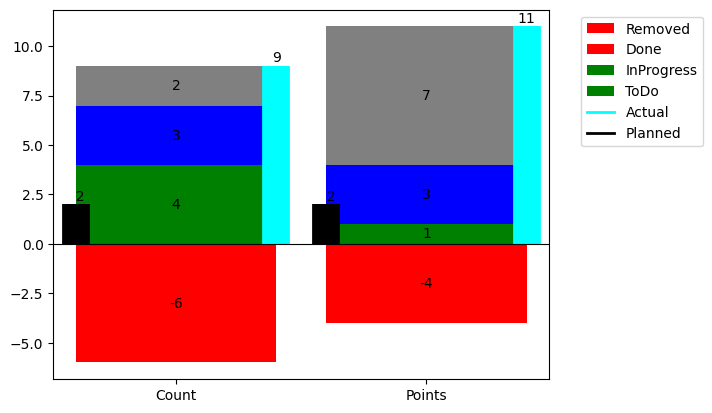

In [237]:
import numpy as np
import matplotlib.pyplot as plt

Removed = DataPoint('Removed', -6, -4, 'red')
ToDo = DataPoint('ToDo', 2, 7, 'grey')
InProgress = DataPoint('InProgress', 3, 3, 'blue')
Done = DataPoint('Done', 4, 1, 'green')

Planned = [2, 2]

col_labels = ['Count', 'Points']

cols = [Removed.color, Done.color, InProgress.color, ToDo.color]
legend = [Removed.name, Done.name, InProgress.name, ToDo.name]
values = [Removed.getValues(), Done.getValues(), InProgress.getValues(), ToDo.getValues()]

data, data_shape, data_stack = cumulateData(values)

ax = plt.subplot(111)

for i in np.arange(0, data_shape[0]):
  bars = ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], color=cols[i],)
  for bar in bars:
     height = bar.get_height()
     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='black')

plt.legend(legend, bbox_to_anchor=(1, 1), loc='upper left')

total_positive_sum = np.sum(data.clip(min=0), axis=0)

for i in range(len(total_positive_sum)):
  lines = ax.vlines(x=i+0.4, ymin=0, ymax=(total_positive_sum[i]), color='cyan', linestyle='solid', linewidth=20,)
  ax.text(i+0.4, (total_positive_sum[i])+0.2, f'{(total_positive_sum[i])}', color='black', horizontalalignment='center')

for i in range(len(Planned)):
  ax.vlines(x=i-0.4, ymin=0, ymax=(Planned[i]), color='black', linestyle='solid', linewidth=20,)
  ax.text(i-0.4, (Planned[i])+0.2, f'{(str(Planned[i]).rjust(3))}', color='black', horizontalalignment='center')

ax.set_xticks(np.arange(data_shape[1]))
ax.set_xticklabels(col_labels)

ax.axhline(0, color='black', linewidth=0.8)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='cyan', lw=2), Line2D([0], [0], color='black', lw=2)]

plt.legend(ax.patches[:4] + custom_lines, legend + ['Actual', 'Planned'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()